In [1]:
# https://dansaber.wordpress.com/2014/05/28/bayesian-regression-with-pymc-a-brief-tutorial/


In [4]:
import pymc 
import random

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
%matplotlib inline

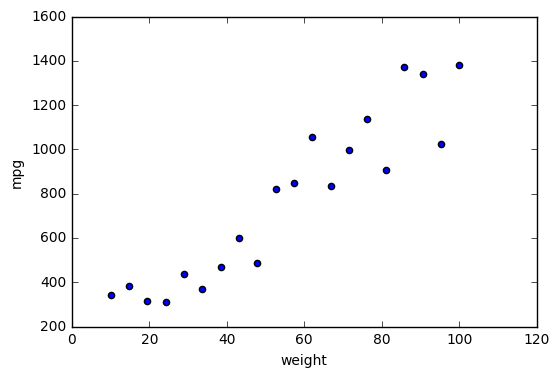

In [6]:
np.random.seed(8675309)
float_df = {}
float_df['weight'] = np.linspace(10,100, 20)
float_df['mpg'] = np.linspace(30,60, 20) * (np.random.random_sample(size=20)*10) + float_df['weight']*10
plt.scatter(float_df['weight'], float_df['mpg'])
plt.xlabel('weight')
plt.ylabel('mpg')

In [4]:
# NOTE: the linear regression model we're trying to solve for is
# given by:
# y = b0 + b1(x) + error
# where b0 is the intercept term, b1 is the slope, and error is
# the error
 
# model the intercept/slope terms of our model as
# normal random variables with comically large variances
b0 = pymc.Normal('b0', 0, 0.0003)
b1 = pymc.Normal('b1', 0, 0.0003)
 
# model our error term as a uniform random variable
err = pymc.Uniform('err', 0, 500)
 
# "model" the observed x values as a normal random variable
# in reality, because x is observed, it doesn't actually matter
# how we choose to model x -- PyMC isn't going to change x's values
x_weight = pymc.Normal('weight', 0, 1, value=np.array(float_df['weight']), observed=True)
 
# this is the heart of our model: given our b0, b1 and our x observations, we want
# to predict y
@pymc.deterministic
def pred(b0=b0, b1=b1, x=x_weight):
    return b0 + b1*x
 
# "model" the observed y values: again, I reiterate that PyMC treats y as
# evidence -- as fixed; it's going to use this as evidence in updating our belief
# about the "unobserved" parameters (b0, b1, and err), which are the
# things we're interested in inferring after all
y = pymc.Normal('y', pred, err, value=np.array(float_df['mpg']), observed=True)
 
# put everything we've modeled into a PyMC model
model = pymc.Model([pred, b0, b1, y, err, x_weight])

In [5]:
mcmc = pymc.MCMC(model)
mcmc.sample(50000, 20000, thin=60)

 [-----------------100%-----------------] 50000 of 50000 complete in 6.2 sec

/Users/balarsen/miniconda3/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


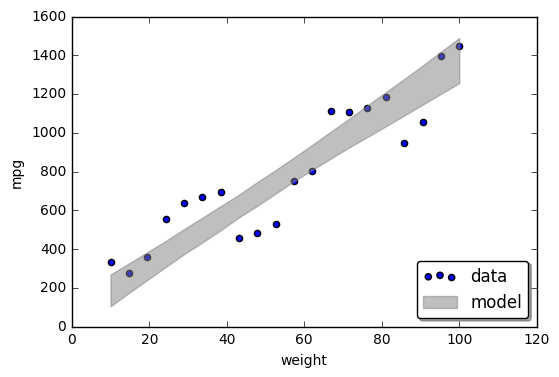

In [15]:
y_min = mcmc.stats()['pred']['quantiles'][2.5]
y_max = mcmc.stats()['pred']['quantiles'][97.5]
y_fit = mcmc.stats()['pred']['mean']

plt.scatter(float_df['weight'], float_df['mpg'], label='data')

plt.fill_between(float_df['weight'], y_min, y_max, color='0.5', alpha=0.5, label='model')
plt.legend(loc='lower right', fancybox=True, shadow=True)
plt.xlabel('weight')
plt.ylabel('mpg')

Plotting b1
Plotting b0
Plotting err


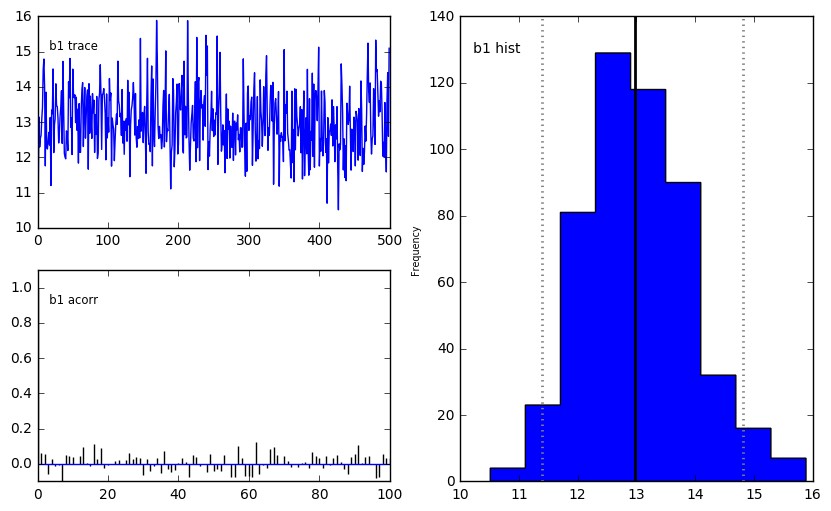

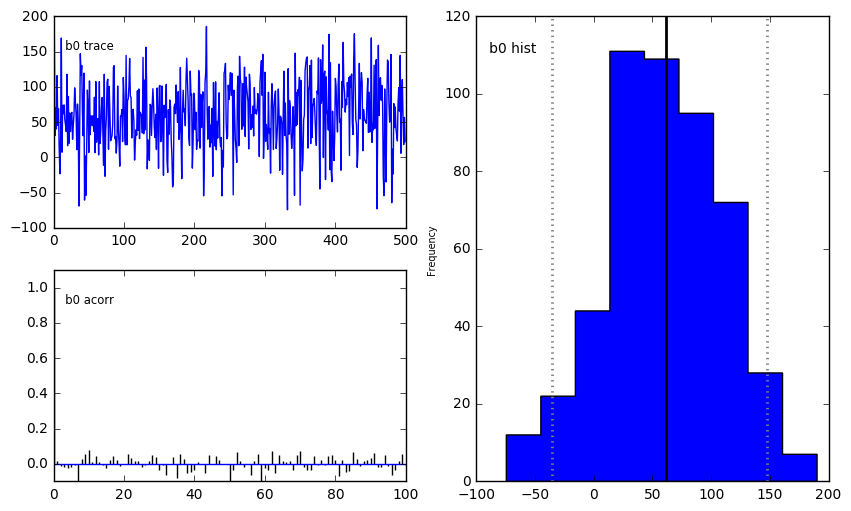

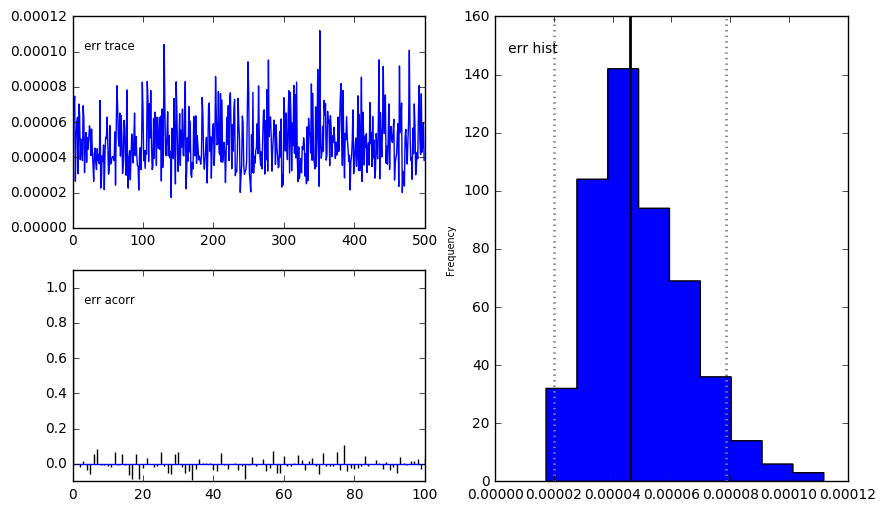

In [14]:
pymc.Matplot.plot(mcmc)

# Also do this in PYMC3

In [7]:
import pymc3 as mc3

In [16]:
np.array(float_df['weight'])

array([  10.        ,   14.73684211,   19.47368421,   24.21052632,
         28.94736842,   33.68421053,   38.42105263,   43.15789474,
         47.89473684,   52.63157895,   57.36842105,   62.10526316,
         66.84210526,   71.57894737,   76.31578947,   81.05263158,
         85.78947368,   90.52631579,   95.26315789,  100.        ])

Applied interval-transform to err and added transformed err_interval_ to model.
Assigned NUTS to b0
Assigned NUTS to b1
Assigned NUTS to err_interval_
 [-----------------100%-----------------] 10000 of 10000 complete in 2.2 sec
b0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.000            0.000            0.000            [0.000, 0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          0.000          0.000


b1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.000            0.000            0.000            [0.000, 0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|===

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121d79f98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121fe7e10>]], dtype=object)

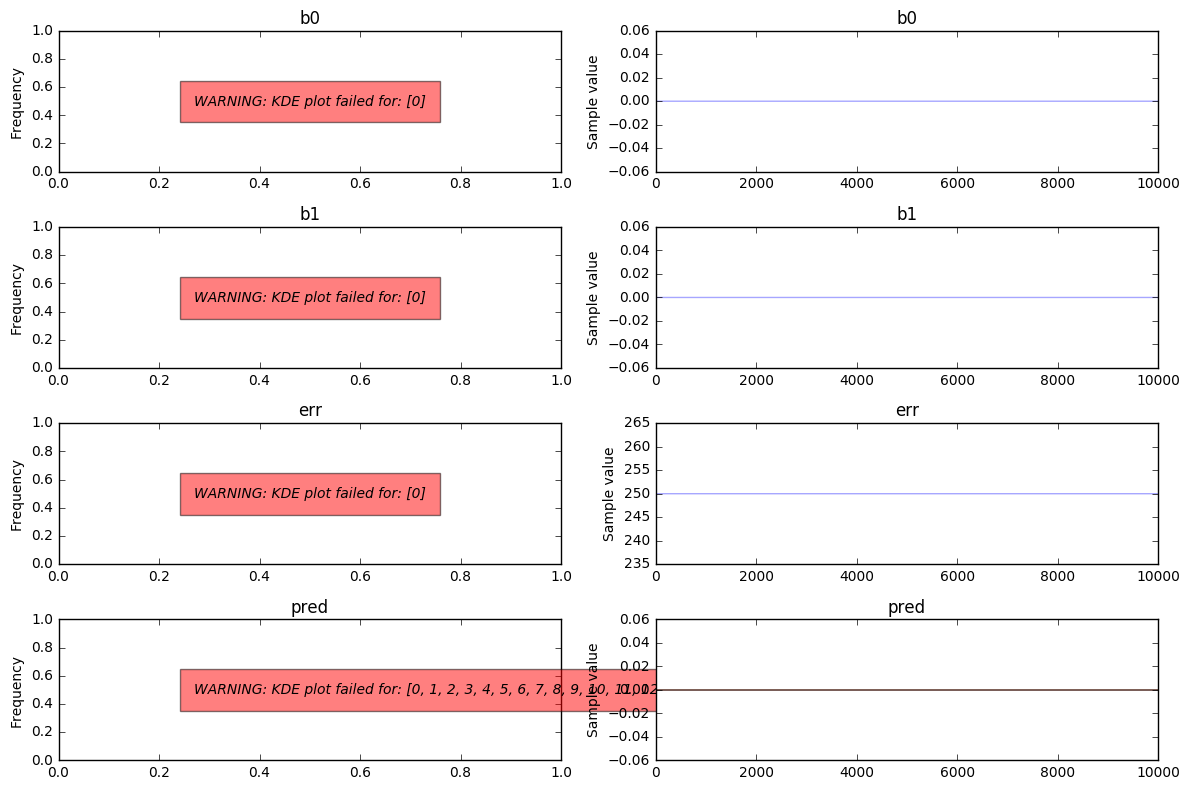

In [14]:
# NOTE: the linear regression model we're trying to solve for is
# given by:
# y = b0 + b1(x) + error
# where b0 is the intercept term, b1 is the slope, and error is
# the error
 
# model the intercept/slope terms of our model as
# normal random variables with comically large variances
with mc3.Model() as model:
    b0 = mc3.Normal('b0', 0, 0.0003)
    b1 = mc3.Normal('b1', 0, 0.0003)

    # model our error term as a uniform random variable
    err = mc3.Uniform('err', 0, 500)

    # "model" the observed x values as a normal random variable
    # in reality, because x is observed, it doesn't actually matter
    # how we choose to model x -- PyMC isn't going to change x's values
    x_weight = mc3.Normal('weight', 0, 0.0003, observed=np.array(float_df['weight']))

    # this is the heart of our model: given our b0, b1 and our x observations, we want
    # to predict y
    pred = mc3.Deterministic('pred', b0 + b1*x_weight)
    #     @mc3.deterministic
    #     def pred(b0=b0, b1=b1, x=x_weight):
    #         return b0 + b1*x

    # "model" the observed y values: again, I reiterate that PyMC treats y as
    # evidence -- as fixed; it's going to use this as evidence in updating our belief
    # about the "unobserved" parameters (b0, b1, and err), which are the
    # things we're interested in inferring after all
    y = mc3.Normal('y', pred, err, observed=np.array(float_df['mpg']))

    trace = mc3.sample(10000)
mc3.summary(trace)
mc3.traceplot(trace)

